# Data discovery with Metacrate

In this notebook, we demonstrate some ways to explore a dataset to discover those parts that are relevant to a certain task.

## Initialization

We have to start with some technical preparation. In particular, we need to load Metacrate and its dependencies into this notebook. Furthermore, we have to import the relevant packages into our namespace.

In [1]:
// For development: Register the local Maven repository to load snapshot versions of Metacrate.
locally {
    val m2Resolver = ammonite.runtime.tools.Resolver.File(
        "m2", "/.m2/repository", ammonite.runtime.tools.Resolvers.MavenPattern, true
    )
    interp.resolvers.update(interp.resolvers() ++ Seq(m2Resolver))
}

In [2]:
// Configure the logging (SLF4J).
System.setProperty("org.slf4j.simpleLogger.defaultLogLevel", "info")
System.setProperty("org.slf4j.simpleLogger.logFile", "tmp/data-discover.log")
import $ivy.`org.slf4j:slf4j-simple:1.7.13`
val logger = org.slf4j.LoggerFactory.getLogger("data-discover")
logger.info("Loading data-discovery notebook...")

res1_0: String = null
res1_1: String = null
import $ivy.$                              

logger: org.slf4j.Logger = org.slf4j.impl.SimpleLogger(data-discover)

In [3]:
// Import required libs into the notebook.
import $ivy.`de.hpi.isg:mdms-jupyter:0.0.3-SNAPSHOT`,
       $ivy.`de.hpi.isg:mdms-tools:0.0.3-SNAPSHOT`,
       $ivy.`de.hpi.isg:mdms-analytics:0.0.3-SNAPSHOT`

// Import the packages.
import de.hpi.isg.mdms.jupyter._
import de.hpi.isg.mdms.analytics._
import de.hpi.isg.mdms.tools._
import de.hpi.isg.mdms.domain.constraints._
import de.hpi.isg.mdms.model.constraints._
import org.qcri.rheem.api._, org.qcri.rheem.core.api._, org.qcri.rheem.java._
import scala.collection.JavaConversions._

import $ivy.$                                       ,
       $ivy.$                                     ,
       $ivy.$                                         

// Import the packages.

import de.hpi.isg.mdms.jupyter._

import de.hpi.isg.mdms.analytics._

import de.hpi.isg.mdms.tools._

import de.hpi.isg.mdms.domain.constraints._

import de.hpi.isg.mdms.model.constraints._

import org.qcri.rheem.api._, org.qcri.rheem.core.api._, org.qcri.rheem.java._

import scala.collection.JavaConversions._

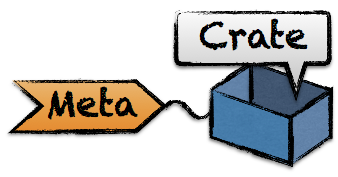

In [4]:
// See if Metacrate is properly loaded
output.showLogo()

## Configuration

At this point, we centralize all the configuration variables of this notebook for your convenience.

In [5]:
// Define the configuration options.
case class Profiles(location: String, 
                    filePattern: String = ".+", 
                    fileType: Import.MetanomeFormat = Import.JsonMetanomeFormat)

case class Dataset(name: String, 
              basedir: String,
              separator: String,
              quote: String,
              hasHeaders: Boolean) {
    def statistics = Profiles(location = s"$basedir/metanome")
    def uccs =       Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_uccs")
    def fds =        Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_fds")
    def inds =       Profiles(location = s"$basedir/metanome",
                              filePattern = ".+_inds")
    def location = s"$basedir/data"
    def sqlFile = s"$basedir/schema.sql"
}

object BiosqlSP extends Dataset(name = "BioSQL-SP",
                              basedir = "biosqlsp",
                              separator = ";",
                              quote = "\"",
                              hasHeaders = false)

object MusicBrainz extends Dataset(name = "MusicBrainz (core)",
                              basedir = "musicbrainz",
                              separator = ";",
                              quote = "\"",
                              hasHeaders = false)

defined class Profiles
defined class Dataset
defined object BiosqlSP
defined object MusicBrainz

In [6]:
// Pick an actual configuration.
object Configuration {
    // No internet access?
    offline = false
    // Which dataset to analyze?
    def dataset: Dataset = BiosqlSP
    // Where to store the data profiles?
    def storageBackend = SqliteBackend(location = s"${dataset.basedir}/data-discovery.db")
    // How to initialize metacrate?
    // csv: Obtain schema information from CSV files.
    // sql: Obtain schema information from SQL file.
    // reload: Don't initialize Metacrate, reuse an existing instance.
    def createFrom = "reload"
}

defined object Configuration

## Preparation

As a first step, we need to obtain an instance of Metacrate that is populated with metadata. This is the basis of all further analyses.

*Option 1.* We can choose to build a completely new Metacrate instance. In that case, we have to
1. initialize an empty instance,
2. load the schema information, and
3. load the relevant data profiles.

*Option 2.* Of course, we can just reload an existing Metacrate instance.

In [7]:
// Create a new Metacrate instance or load one.
implicit var metacrate = 
    if (Configuration.createFrom != "reload")
        createMetacrate(storageBackend = Configuration.storageBackend, isOverwrite = true)
    else
        loadMetacrate(storageBackend = Configuration.storageBackend)

// Initialize Rheem, which serves Metacrate as execution engine.
implicit val rheemCtx = new RheemContext() withPlugin Java.basicPlugin

metacrate: de.hpi.isg.mdms.model.MetadataStore = MetadataStore[SQLiteInterface[class org.sqlite.SQLiteConnection]]
rheemCtx: RheemContext = org.qcri.rheem.core.api.RheemContext@28a4da19

In [8]:
// Initialize the schema.
Configuration.createFrom match {
    case "csv" =>
        Import.createSchemaFromCsvFiles(
            schemaName = Configuration.dataset.name,
            fileLocation = Configuration.dataset.location,
            fieldSeparator = Configuration.dataset.separator,
            quoteChar = Configuration.dataset.quote,
            hasHeader = Configuration.dataset.hasHeaders,
            sqlFile = Configuration.dataset.sqlFile
        )
    case "sql" =>
        Import.createSchemaFromSqlFile(
            schemaName = Configuration.dataset.name,
            sqlFileLocation = Configuration.dataset.sqlFile
        )
    case "reload" =>
        // nothing to do 
}
val schema = metacrate.getSchemaByName(Configuration.dataset.name)

res7_0: Any = ()
schema: de.hpi.isg.mdms.model.targets.Schema = Schema[BioSQL-SP, , 0fffffff]

In [9]:
if (Configuration.createFrom != "reload") {
    // Import statistics from Metanome.
    Import.importMetanomeStatistics(
        fileLocation = Configuration.dataset.statistics.location,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    // Import dependencies from Metanome.
    Import.importMetanomeDependencies[UniqueColumnCombination](
        fileLocation = Configuration.dataset.uccs.location,
        fileType = Configuration.dataset.uccs.fileType,
        filePattern = Configuration.dataset.uccs.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    Import.importMetanomeDependencies[FunctionalDependency](
        fileLocation = Configuration.dataset.fds.location,
        fileType = Configuration.dataset.fds.fileType,
        filePattern = Configuration.dataset.fds.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
    Import.importMetanomeDependencies[InclusionDependency](
        fileLocation = Configuration.dataset.inds.location,
        fileType = Configuration.dataset.inds.fileType,
        filePattern = Configuration.dataset.inds.filePattern,
        userDefinedIdPrefix = "metanome-",
        schema = schema
    )
}

In [10]:
if (Configuration.createFrom != "reload" && Configuration.dataset.sqlFile != null) {
    // If available, we can also import constraints from SQL definitions.
    Import.importPrimaryKeyDefinitions(sqlFile = Configuration.dataset.sqlFile,
                                       schema = schema,
                                       userDefinedId = "sql-primary-keys")
    Import.importForeignKeyDefinitions(sqlFile = Configuration.dataset.sqlFile,
                                       schema = schema,
                                       userDefinedId = "sql-foreign-keys")
}

In [11]:
if (Configuration.createFrom == "csv") {
    // If we have the data, we can profile some additional column summaries directly.
    Profiling.profileQGramSketches(schema = schema,
                                   userDefinedId = "3-gram-sketches",
                                   q = 3)
    Profiling.profileQGramSignatures(schema = schema,
                                     userDefinedId = "3-gram-signatures",
                                     q = 3)
}

## Analytics

At last, we arrive at the interesting part of this notebook. In the following, we are going to query and analyze the data profiles stored in our Metacrate instance, _with a specific focus on data discovery._

### Metadata overview

Let us start by summarizing the data profiles loaded into Metacrate.

In [12]:
// List the data profile collections in our Metacrate instance.
output.table(
    elements = iterableAsScalaIterable(metacrate.getConstraintCollections),
    columns = Seq("ID" -> ((cc: ConstraintCollection[_]) => cc.getId),
                  "User ID" -> ((cc: ConstraintCollection[_]) => Option(cc.getUserDefinedId) getOrElse "n/a"),
                  "Type" -> ((cc: ConstraintCollection[_]) => cc.getConstraintClass.getSimpleName),
                  "Description" -> ((cc: ConstraintCollection[_]) => cc.getDescription),
                  "Data profiles [#]" -> ((cc: ConstraintCollection[_]) => cc.getConstraints.size)
    )
)

ID,User ID,Type,Description,Data profiles [#]
140708058,metanome-number-stats,NumberColumnStatistics,Statistics for BioSQL-SP (number statistics),43
185957480,metanome-inds,InclusionDependency,IND import (Thu Nov 16 12:56:12 CET 2017),932
288629367,sql-primary-keys,UniqueColumnCombination,Primary keys loaded from biosqlsp/schema.sql,13
446946034,metanome-tuple-counts,TupleCount,Statistics for BioSQL-SP (tuple counts),15
552889854,3-gram-sketches,Vector,Q-gram sketches profiled for schema BioSQL-SP,75
565080721,metanome-text-stats,TextColumnStatistics,Statistics for BioSQL-SP (text statistics),13
838673253,3-gram-signatures,Signature,Q-gram sketches profiled for schema BioSQL-SP,75
1055861676,metanome-uccs,UniqueColumnCombination,UCC import (Thu Nov 16 12:56:12 CET 2017),31
1139683997,sql-foreign-keys,InclusionDependency,Foreign keys loaded from biosqlsp/schema.sql,19
1403845728,metanome-column-stats,ColumnStatistics,Statistics for BioSQL-SP (column statistics),75


### Discover similar columns

When a user finds a certain column that appears to be relevant for her task at hand, she might wonder whether there are other columns containing similar content (and might thus be relevant).
Here, we show how q-gram sketches reveal columns with similar content. Moreover, such a similarity measure allows us to cluster the columns to find column categories.

In [13]:
// Cluster the columns by their 3-gram sketches.
query { implicit engine =>
    Columns.clusterVectors(vectors = metacrate.getConstraintCollection("3-gram-sketches"), k = 10)
}
.storeConstraintCollection(userDefinedId = "column-clustering",
                           scope = Seq(schema),
                           overwrite = true)

res12: ConstraintCollection[ColumnClusterAssignment] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=231992429]

In [14]:
// Visualize the clustering and the column similarities in a grid.
locally {
    val tiles = query { implicit engine =>
        def length(vals: Array[Double]): Double = math.sqrt(vals.map(v => v * v).reduce(_ + _))
        def cosineSimilarity(v1: Array[Double], v2: Array[Double]): Double = {
            v1.zip(v2).map(pair => pair._1 * pair._2).reduce(_ + _) / length(v1) / length(v2)
        }

        val clustering = metacrate.loadConstraints[ColumnClusterAssignment]("column-clustering")
        val sketchesWithCluster = metacrate.loadConstraints[Vector]("3-gram-sketches")
            .keyBy(_.getColumnId).join(clustering.keyBy(_.columnId))
            .assemble((sketch, clustering) => (sketch.getColumnId, sketch.getValues, clustering.clusterId))

        sketchesWithCluster.cartesian(sketchesWithCluster.map(x=>x))
            .map { case pair => 
                  val (v1, v2) = (pair.field0, pair.field1)
                  val sim = cosineSimilarity(v1._2, v2._2)
                  val cluster = if (v1._3 == v2._3) v1._3 else -1
                  (v1._1, v2._1, sim, cluster)
            }
            .filter { case (id1, id2, sim, cluster) => !java.lang.Double.isNaN(sim) }
            .resolveIds { case ((id1, id2, sim, cluster), r) => 
                         Tile(row=r(id1), column=r(id2), opacity=sim, color=cluster) }
    }
    
    val rows = query { implicit engine =>
        metacrate.loadConstraints[ColumnClusterAssignment]("column-clustering")
        .resolveIds((assign, r) => 
                    Category(name = r(assign.columnId), order = assign.clusterId)
        )
    }
    
    
    val columns = query { implicit engine =>
        metacrate.loadConstraints[ColumnClusterAssignment]("column-clustering")
        .resolveIds((assign, r) => 
                    Category(name = r(assign.columnId), order = assign.clusterId)
        )
    }
    
    tiles.plotGrid(rows=rows, columns=columns, width=700, height=700)
}

### Discover composite fields

It is particularly hard to identify opportunities to join columns whenever the involved columns need transformations first. A typical pattern is that we need to add prefixes and/or suffixes to values (e.g., `5231` &rarr; `ID5231`).

In [15]:
// Detect potential subset fields, color by the target table.
query { implicit engine =>
    val idUtils = metacrate.getIdUtils
    Columns.findSubsetFields(schema = schema,
                             qGramSketches = metacrate.getConstraintCollection("3-gram-sketches"),
                             qGramSignatures = metacrate.getConstraintCollection("3-gram-signatures"),
                             minResemblance = 0.2,
                             minInclusion = 0.2
    )
    .resolveIds { case ((col1, col2, resemblance, inclusion), r) => 
         Tile(row=r(col1), column=r(col2), opacity=(resemblance + inclusion)/2, color=idUtils.getTableId(col2))
    }
}
.plotGrid(width=700, height=700)

## Discover join paths

Schema graphs are usually acyclic and complex. It can thus be tricky to identify join paths between tables to connect entities.
We can use our data profiles along with derived measures to propose reasonable join paths between tables.

In [16]:
// Estimate the similarity of tables via their foreign key relationships.
query { implicit engine =>
    TableSimilarity.calculate(
        foreignKeys = metacrate.getConstraintCollection("sql-foreign-keys"),
        tupleCounts = metacrate.findConstraintCollection[TupleCount](schema),
        columnStatistics = metacrate.findConstraintCollection[ColumnStatistics](schema),
        transitiveHull = false
    )
}
.storeConstraintCollection(scope = Seq(schema),
                           userDefinedId = "table-similarity",
                           overwrite = true)

res15: ConstraintCollection[TableSimilarity] = RDBMSConstraintCollection [scope=[Schema[BioSQL-SP, , 0fffffff]], getId()=1754918897]

In [17]:
// Use the similarity measure to propose join paths between a root table and every other table.
locally {
    val rootTable = schema.getTableByName("bioentry")
    val edges = query { implicit engine =>
        TableSimilarity.buildJoinTree(root = rootTable,
                                     foreignKeys = metacrate.getConstraintCollection("sql-foreign-keys"),
                                     tableSimilarities = metacrate.getConstraintCollection("table-similarity"))
           .resolveIds { case (JoinTreeEdge(parent, child, similarity, childRef), r) =>
                GraphEdge(source = r(if (childRef) parent else child),
                          destination = r(if (childRef) child else parent))
           }
    }
    
    val vertices = query { implicit engine =>
        TableSimilarity.buildJoinTree(root = rootTable,
                                     foreignKeys = metacrate.getConstraintCollection("sql-foreign-keys"),
                                     tableSimilarities = metacrate.getConstraintCollection("table-similarity"))
            .flatMap { case JoinTreeEdge(parent, child, similarity, _) => 
                      Seq((parent, 1d), (child, similarity)) 
            }
            .reduceByKey(_._1, { case ((table, sim1), (_, sim2)) => (table, math.min(sim1, sim2)) })
            .resolveIds { case ((table, sim), r) => 
                 GraphVertex(name = r(table), 
                             size = (3 + 7 * sim).toInt, 
                             color = if (table == rootTable.getId) 0 else 1) 
            }
    }
    
    edges.plotDirectedGraph(height = "500px", nodes = vertices)
}

Freeze 
  
 Link distance: 
  
 Charge: